In [1]:
import numpy as np
from spec_id import Oldest_galaxy,Analyze_LH_lwa,Median_w_Error_cont,Median_w_Error, Gen_spec,\
    Scale_model
from scipy.interpolate import interp1d, interp2d
from scipy.ndimage.interpolation import rotate
from astropy.cosmology import Planck13 as cosmo
from astropy.io import ascii, fits
from astropy.table import Table
import grizli
from matplotlib import gridspec
import rpy2
import rpy2.robjects as robjects
R = robjects.r
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in", "ytick.direction": "in"})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [2]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
galDB = galDB.query('ids != 14713 and ids != 38126 and ids != 48631')
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

([], <a list of 0 Text yticklabel objects>)

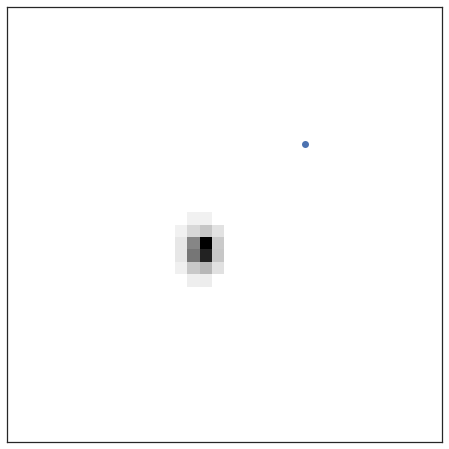

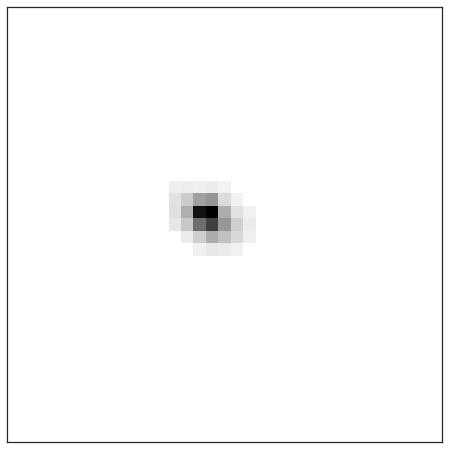

In [46]:
%matplotlib inline
indata = fits.open('../data/galaxy_flts/n37686_flt.fits')

plt.figure(figsize=[8,8])
plt.imshow(indata[1].data)
plt.plot(514,514,'o')
plt.xticks([])
plt.yticks([])
plt.axis([490,525,490,525])

indata = fits.open('../data/galaxy_flts/n21156_flt.fits')

plt.figure(figsize=[8,8])
plt.imshow(indata[1].data[490:525,490:525])
plt.xticks([])
plt.yticks([])


([], <a list of 0 Text yticklabel objects>)

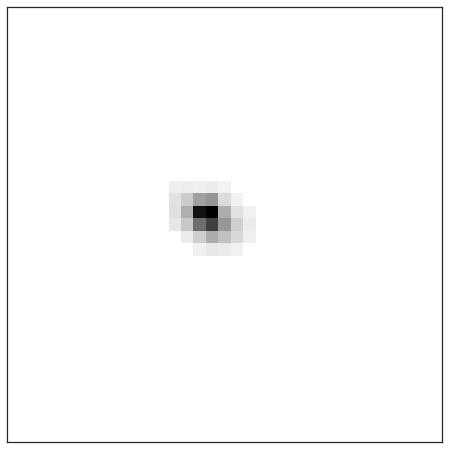

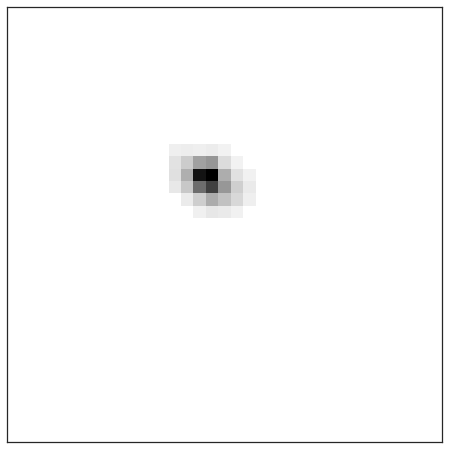

In [46]:
%matplotlib inline

indata = fits.open('../data/galaxy_flts/%s_flt.fits' % mzDB['gids'][61])
plt.figure(figsize=[8,8])
plt.imshow(indata[1].data[490:525,490:525])
plt.xticks([])
plt.yticks([])

indata2 = np.append(indata[1].data[3:],np.zeros([3,1014]),axis=0)
plt.figure(figsize=[8,8])
plt.imshow(indata2[490:525,490:525])
plt.xticks([])
plt.yticks([])

In [47]:
1014/2. +15

522.0

In [52]:
dt = fits.open('../data/galaxy_flts/n21156_flt.fits')
fits.update('../data/galaxy_flts/n21156_flt.fits', indata2, dt[1].header, 1)

In [49]:
class Gen_spec_2(object):
    def __init__(self, galaxy_id, redshift, pad=100, delayed = True,minwv = 7900, maxwv = 11300):
        self.galaxy_id = galaxy_id
        self.redshift = redshift
        self.pad = pad
        self.delayed = delayed

        gal_wv, gal_fl, gal_er = np.load('../spec_stacks_june14/%s_stack.npy' % self.galaxy_id)
        self.flt_input = '../data/galaxy_flts/%s_2_flt.fits' % self.galaxy_id

        IDX = [U for U in range(len(gal_wv)) if minwv <= gal_wv[U] <= maxwv]

        self.gal_wv_rf = gal_wv[IDX] / (1 + self.redshift)
        self.gal_wv = gal_wv[IDX]
        self.gal_fl = gal_fl[IDX]
        self.gal_er = gal_er[IDX]

        self.gal_wv_rf = self.gal_wv_rf[self.gal_fl > 0 ]
        self.gal_wv = self.gal_wv[self.gal_fl > 0 ]
        self.gal_er = self.gal_er[self.gal_fl > 0 ]
        self.gal_fl = self.gal_fl[self.gal_fl > 0 ]

        ## Create Grizli model object
        sim_g102 = grizli.model.GrismFLT(grism_file='', verbose=False,
                                         direct_file=self.flt_input,
                                         force_grism='G102', pad=self.pad)

        sim_g102.photutils_detection(detect_thresh=.025, verbose=True, save_detection=True)

        keep = sim_g102.catalog['mag'] < 29
        c = sim_g102.catalog

        sim_g102.compute_full_model(ids=c['id'][keep], mags=c['mag'][keep], verbose=False)

        ## Grab object near the center of the image
        dr = np.sqrt((sim_g102.catalog['x_flt'] - 579) ** 2 + (sim_g102.catalog['y_flt'] - 522) ** 2)
        ix = np.argmin(dr)
        id = sim_g102.catalog['id'][ix]

        ## Spectrum cutouts
        self.beam = grizli.model.BeamCutout(sim_g102, beam=sim_g102.object_dispersers[id]['A'], conf=sim_g102.conf)

    def Sim_spec(self, metal, age, tau):
        import pysynphot as S
        model = '../../../fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(metal, age, tau)

        wave, fl = np.load(model)
        spec = S.ArraySpectrum(wave, fl, fluxunits='flam')
        spec = spec.redshift(self.redshift).renorm(1., 'flam', S.ObsBandpass('wfc3,ir,f105w'))
        spec.convert('flam')
        ## Compute the models
        self.beam.compute_model(spectrum_1d=[spec.wave, spec.flux])

        ## Extractions the model (error array here is meaningless)
        w, f, e = self.beam.beam.optimal_extract(self.beam.model, bin=0)

        ifl = interp1d(w, f)(self.gal_wv)

        ## Get sensitivity function
        fwv, ffl = [self.beam.beam.lam, self.beam.beam.sensitivity / np.max(self.beam.beam.sensitivity)]
        filt = interp1d(fwv, ffl)(self.gal_wv)

        adj_ifl = ifl /filt

        C = Scale_model(self.gal_fl, self.gal_er, adj_ifl)

        self.fl = C * adj_ifl

    def Fit_lwa(self, fit_Z, fit_t, metal_array, age_array, tau_array):
        
        lwa_grid = np.load('../data/light_weight_scaling_3.npy')
        chi = []
        good_age =[]
        good_tau =[]
        for i in range(len(tau_array)):
            for ii in range(age_array.size):
                
                lwa = lwa_grid[np.argwhere(np.round(metal_array,3) == np.round(fit_Z,3))[0][0]][ii][i]
                
                if (fit_t - 0.1) < lwa < (fit_t + 0.1):
                    self.Sim_spec(fit_Z,age_array[ii],tau_array[i])
                    chi.append(sum(((self.gal_fl - self.fl) / self.gal_er)**2))
                    good_age.append(age_array[ii])
                    good_tau.append(tau_array[i])

        self.bfage = np.array(good_age)[chi == min(chi)][0]
        self.bftau = np.array(good_tau)[chi == min(chi)][0]
        if self.bftau == 0.0:
            self.bftau = int(0)
        self.Sim_spec(fit_Z, self.bfage, self.bftau)    

In [53]:
spec = Gen_spec(galDB['gids'][61], galDB['hi_res_specz'][61],delayed=True,maxwv=11400)
spec.Fit_lwa(galDB['Z_lwa'][61],galDB['t_lwa'][61],metal,age,tau)

spec2 = Gen_spec_2(galDB['gids'][61], galDB['hi_res_specz'][61],delayed=True,maxwv=11400)
spec2.Fit_lwa(galDB['Z_lwa'][61],galDB['t_lwa'][61],metal,age,tau)

../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat
../data/galaxy_flts/n21156_2_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_2_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_2_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_2_flt: save ../data/galaxy_flts/n21156_2_flt.detect_seg.fi

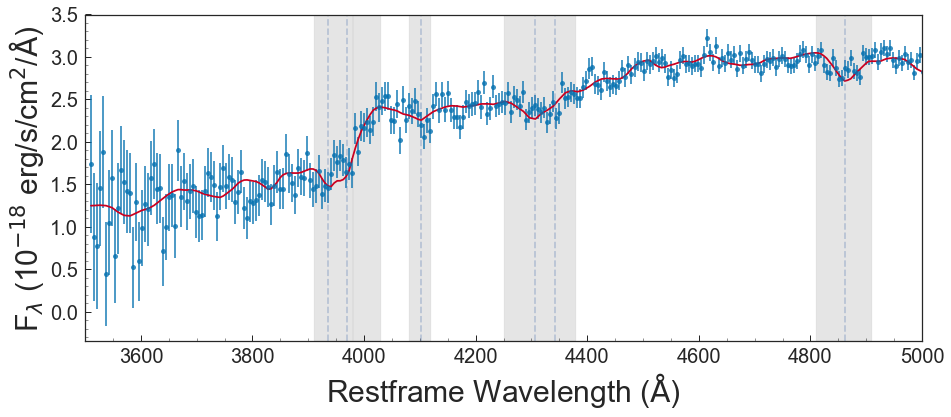

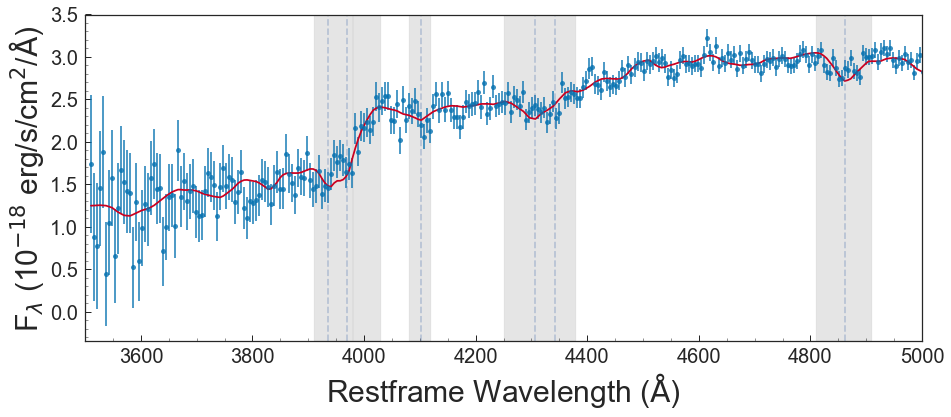

In [54]:
plt.figure(figsize=(15,6))
plt.errorbar(spec.gal_wv_rf,spec.gal_fl*1E18,spec.gal_er*1E18,fmt='o',color='#0571b0', alpha = .8,ms=5)
plt.plot(spec.gal_wv_rf,spec.fl*1E18, color='#ca0020')
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(5120, 5240, color='k', alpha=.1)
plt.xlim(3500,5000)
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\\rm \AA$)',size=30)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc=4,fontsize=20)
plt.minorticks_on()
plt.show()
plt.close()

plt.figure(figsize=(15,6))
plt.errorbar(spec2.gal_wv_rf,spec2.gal_fl*1E18,spec2.gal_er*1E18,fmt='o',color='#0571b0', alpha = .8,ms=5)
plt.plot(spec2.gal_wv_rf,spec2.fl*1E18, color='#ca0020')
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(5120, 5240, color='k', alpha=.1)
plt.xlim(3500,5000)
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\\rm \AA$)',size=30)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc=4,fontsize=20)
plt.minorticks_on()
plt.show()
plt.close()

In [55]:
galDB.hi_res_specz[61]

1.251000000000001